# Tutorial to use ctapipe tools and component 

## Context

Tool and Component are 2 modules of ctapipe, Tool is a high level module to analyse raw data (fits.fz files). This module use Component to perform computation on the raw data. Basically, we can create a class (MyTool) which inherits of Tool, where we can define 2 Component (Comp_A and Comp_B). Thus, with an instance of MyTool, we can loop over event within raw data, and for each event apply sucessively Comp_A, Comp_B. 

A ctapipe tutorial is accessible here : https://ctapipe.readthedocs.io/en/stable/auto_examples/core/command_line_tools.html#sphx-glr-auto-examples-core-command-line-tools-py

You can find documentation of ctapipe Tool and Component : 

https://ctapipe.readthedocs.io/en/stable/api-reference/tools/index.html


https://ctapipe.readthedocs.io/en/stable/api/ctapipe.core.Component.html

Within nectarchain, we implemented within the nectarchain.makers module both a top level Tool and Component from which all the nectarchain Component and Tool should inherit.

In this tutorial, we explain quickly how we can use Tool and Component to develop the nectarchain software, as an example there is the implementation of a PedestalTool which extract pedestal   

### Imports

In [1]:
import numpy as np
import pathlib
import os

import matplotlib.pyplot as plt

from ctapipe_io_nectarcam.containers import NectarCAMDataContainer
from ctapipe_io_nectarcam import constants

from ctapipe.core.traits import ComponentNameList
from ctapipe.containers import Field
from ctapipe.core.traits import Integer
from ctapipe.core import Component
from ctapipe.io import HDF5TableReader


from nectarchain.makers import EventsLoopNectarCAMCalibrationTool
from nectarchain.makers.component import NectarCAMComponent, ArrayDataComponent
from nectarchain.data.container import (
    NectarCAMContainer,
    ArrayDataContainer,
    TriggerMapContainer,
)
from nectarchain.utils import ComponentUtils

/home/ggroller/.conda/envs/nectarchain/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tools = EventsLoopNectarCAMCalibrationTool()
tools

2024-01-12 16:42:05,923 nectarchain.makers.core WARNING the componentName in componentsList must be defined in the nectarchain.makers.component module, otherwise the import of the componentName will raise an error


componentsList,[],". Possible values: ['ChargesComponent', 'WaveformsComponent', 'FlatFieldSingleNominalSPENectarCAMComponent', 'PhotoStatisticNectarCAMComponent', 'FlatFieldSingleNominalSPEStdNectarCAMComponent', 'FlatFieldSingleHHVSPENectarCAMComponent', 'FlatFieldSingleHHVSPEStdNectarCAMComponent', 'FlatFieldCombinedSPEStdNectarCAMComponent'] (default: traitlets.Undefined)"
config_files,[],(default: traitlets.Undefined)
events_per_slice,None,"number of events that will be treat before to pull the buffer and write to disk, if None, all the events will be loaded (default: None)"
log_config,{},(default: traitlets.Undefined)
log_datefmt,%Y-%m-%d %H:%M:%S,The date format used by logging formatters for %(asctime)s (default: %Y-%m-%d %H:%M:%S)
log_file,None,Filename for the log (default: None)
log_file_level,INFO,Logging Level for File Logging (default: INFO)
log_format,[%(name)s]%(highlevel)s %(message)s,The Logging format template (default: [%(name)s]%(highlevel)s %(message)s)
log_level,30,Set the log level by value or name. (default: 30)
logging_config,{},(default: traitlets.Undefined)
max_events,None,maximum number of events to be loaded (default: None)


In [4]:
tools.classes

[nectarchain.makers.core.EventsLoopNectarCAMCalibrationTool,
 ctapipe.io.hdf5tableio.HDF5TableWriter,
 nectarchain.data.container.eventSource.LightNectarCAMEventSource,
 nectarchain.makers.component.core.NectarCAMComponent,
 nectarchain.makers.component.chargesComponent.ChargesComponent,
 nectarchain.makers.component.waveformsComponent.WaveformsComponent,
 nectarchain.makers.component.FlatFieldSPEComponent.FlatFieldSingleNominalSPENectarCAMComponent,
 nectarchain.makers.component.photostatistic_component.PhotoStatisticNectarCAMComponent,
 nectarchain.makers.component.FlatFieldSPEComponent.FlatFieldSingleNominalSPEStdNectarCAMComponent,
 nectarchain.makers.component.FlatFieldSPEComponent.FlatFieldSingleHHVSPENectarCAMComponent,
 nectarchain.makers.component.FlatFieldSPEComponent.FlatFieldSingleHHVSPEStdNectarCAMComponent,
 nectarchain.makers.component.FlatFieldSPEComponent.FlatFieldCombinedSPEStdNectarCAMComponent]

The only thing to add to to fill the componentList field, which contains the names of the component to be apply on events. 

Then we will define a very simple component to compute the pedestal of each events. 

### Definition of container to store extracted data on disk

In [11]:
class MyContainer(NectarCAMContainer):
    run_number = Field(
        type=np.uint16,
        description="run number associated to the waveforms",
    )
    npixels = Field(
        type=np.uint16,
        description="number of effective pixels",
    )
    pixels_id = Field(type=np.ndarray, dtype=np.uint16, ndim=1, description="pixel ids")
    ucts_timestamp = Field(
        type=np.ndarray, dtype=np.uint64, ndim=1, description="events ucts timestamp"
    )
    event_type = Field(
        type=np.ndarray, dtype=np.uint8, ndim=1, description="trigger event type"
    )
    event_id = Field(type=np.ndarray, dtype=np.uint32, ndim=1, description="event ids")

    pedestal_hg = Field(
        type=np.ndarray, dtype=np.uint16, ndim=2, description="The high gain pedestal"
    )
    pedestal_lg = Field(
        type=np.ndarray, dtype=np.uint16, ndim=2, description="The low gain pedestal"
    )

### Definition of our Component

In [13]:
class MyComp(NectarCAMComponent):
    window_shift = Integer(
        default_value=4,
        help="the time in ns before the peak to extract charge",
    ).tag(config=True)

    window_width = Integer(
        default_value=12,
        help="the duration of the extraction window in ns",
    ).tag(config=True)

    def __init__(self, subarray, config=None, parent=None, *args, **kwargs):
        super().__init__(
            subarray=subarray, config=config, parent=parent, *args, **kwargs
        )
        ## If you want you can add here members of MyComp, they will contain interesting quantity during the event loop process

        self.__ucts_timestamp = []
        self.__event_type = []
        self.__event_id = []

        self.__pedestal_hg = []
        self.__pedestal_lg = []

    ##This method need to be defined !
    def __call__(self, event: NectarCAMDataContainer, *args, **kwargs):
        self.__event_id.append(np.uint32(event.index.event_id))
        self.__event_type.append(event.trigger.event_type.value)
        self.__ucts_timestamp.append(event.nectarcam.tel[0].evt.ucts_timestamp)

        wfs = []
        wfs.append(event.r0.tel[0].waveform[constants.HIGH_GAIN][self.pixels_id])
        wfs.append(event.r0.tel[0].waveform[constants.LOW_GAIN][self.pixels_id])

        #####THE JOB IS HERE######
        for i, pedestal in enumerate([self.__pedestal_hg, self.__pedestal_lg]):
            index_peak = np.argmax(wfs[i])
            signal_start = index_peak - self.window_shiftclasses
            signal_stop = index_peak + self.window_width - self.window_shift
            if signal_start < 0:
                signal_stop = self.window_width
                signal_start = 0
            if signal_stop > constants.N_SAMPLES:
                signal_stop = constants.N_SAMPLES
                signal_start = constants.N_SAMPLES - self.window_width
            pedestal.append(
                (
                    np.sum(wfs[i][:, 0:signal_start], axis=1)
                    + np.sum(wfs[i][:, signal_stop:], axis=1)
                )
                / (constants.N_SAMPLES - self.window_width)
            )

    ##This method need to be defined !
    def finish(self):
        output = MyContainer(
            run_number=MyContainer.fields["run_number"].type(self._run_number),
            npixels=MyContainer.fields["npixels"].type(self._npixels),
            pixels_id=MyContainer.fields["pixels_id"].dtype.type(self._pixels_id),
            ucts_timestamp=MyContainer.fields["ucts_timestamp"].dtype.type(
                self.__ucts_timestamp
            ),
            event_type=MyContainer.fields["event_type"].dtype.type(self.__event_type),
            event_id=MyContainer.fields["event_id"].dtype.type(self.__event_id),
            pedestal_hg=MyContainer.fields["pedestal_hg"].dtype.type(
                self.__pedestal_hg
            ),
            pedestal_lg=MyContainer.fields["pedestal_lg"].dtype.type(
                self.__pedestal_lg
            ),
        )
        return output

### Definition of our Tool

Now we can define out Tool, we have just to add our component "MyComp" in the ComponentList : 

In [5]:
def get_valid_component():
    return NectarCAMComponent.non_abstract_subclasses()


class MyTool(EventsLoopNectarCAMCalibrationTool):
    name = "PedestalTutoNectarCAM"

    componentsList = ComponentNameList(
        NectarCAMComponent,
        default_value=["MyComp"],
        help="List of Component names to be apply, the order will be respected",
    ).tag(config=True)

    #######   THIS PART IS NEEDED NOW #####

    # This part uis needed because the component defined outside of the nectarchain
    # module is not accessible from the module (with eval(componentName)).
    # This issus should be fixed soon.
    def __new__(cls, *args, **kwargs):
        _cls = super(EventsLoopNectarCAMCalibrationTool, cls).__new__(
            cls, *args, **kwargs
        )

        for componentName in _cls.componentsList:
            configurable_traits = ComponentUtils.get_configurable_traits(
                eval(componentName)
            )
            _cls.add_traits(**configurable_traits)
            _cls.aliases.update(
                {key: f"{componentName}.{key}" for key in configurable_traits.keys()}
            )
        return _cls

    def _get_provided_component_kwargs(self, componentName: str):
        component_kwargs = ComponentUtils.get_configurable_traits(eval(componentName))
        output_component_kwargs = {}
        for key in component_kwargs.keys():
            if hasattr(self, key):
                output_component_kwargs[key] = getattr(self, key)
        return output_component_kwargs

    #####################################################################

    # def __init__(self,*args,**kwargs) :
    #       super().__init__(*args,**kwargs)

    def _init_output_path(self):
        if self.max_events is None:
            filename = f"{self.name}_run{self.run_number}.h5"
        else:
            filename = f"{self.name}_run{self.run_number}_maxevents{self.max_events}.h5"
        self.output_path = pathlib.Path(
            f"{os.environ.get('NECTARCAMDATA','/tmp')}/tutorials/{filename}"
        )

In [6]:
tool = MyTool(
    progress_bar=True, run_number=4943, max_events=500, log_level=20, window_width=14
)

In [7]:
tool.componentsList

['MyComp']

In [8]:
tool

SubComponents,None,". Possible values: ['TelescopeComponent', 'FeatureGenerator', 'QualityQuery', 'EventTypeFilter', 'EventSeeker', 'TableLoader', 'HDF5Merger', 'MuonRingFitter', 'DataWriter', 'SPEalgorithm', 'PhotoStatisticAlgorithm', 'SoftwareTrigger', 'ImageModifier', 'ImageProcessor', 'MuonIntensityFitter', 'MuonProcessor', 'CameraCalibrator', 'NectarCAMR0Corrections', 'TailcutsImageCleaner', 'MARSImageCleaner', 'FACTImageCleaner', 'TimeConstrainedImageCleaner', 'NeighborAverage', 'FullWaveformSum', 'FixedWindowSum', 'GlobalPeakWindowSum', 'LocalPeakWindowSum', 'SlidingWindowMaxSum', 'NeighborPeakWindowSum', 'TwoPassWindowSum', 'FlashCamExtractor', 'BaselineSubtractedNeighborPeakWindowSum', 'NullDataVolumeReducer', 'TailCutsDataVolumeReducer', 'MyComp', 'ChargesComponent', 'WaveformsComponent', 'FlatFieldSingleNominalSPENectarCAMComponent', 'PhotoStatisticNectarCAMComponent', 'FlatFieldSingleNominalSPEStdNectarCAMComponent', 'FlatFieldSingleHHVSPENectarCAMComponent', 'FlatFieldSingleHHVSPEStdNectarCAMComponent', 'FlatFieldCombinedSPEStdNectarCAMComponent', 'ImageQualityQuery', 'ImageParameterQuery', 'RingQuery', 'HDF5TableWriter', 'HDF5TableReader', 'HDF5EventSource', 'SimTelEventSource', 'NectarCAMEventSource', 'LightNectarCAMEventSource', 'ManualGainSelector', 'ThresholdGainSelector', 'SPEnominalalgorithm', 'SPEHHValgorithm', 'SPEnominalStdalgorithm', 'SPECombinedalgorithm', 'SPEHHVStdalgorithm'] (default: None)"
componentsList,['MyComp'],". Possible values: ['MyComp', 'ChargesComponent', 'WaveformsComponent', 'FlatFieldSingleNominalSPENectarCAMComponent', 'PhotoStatisticNectarCAMComponent', 'FlatFieldSingleNominalSPEStdNectarCAMComponent', 'FlatFieldSingleHHVSPENectarCAMComponent', 'FlatFieldSingleHHVSPEStdNectarCAMComponent', 'FlatFieldCombinedSPEStdNectarCAMComponent'] (default: traitlets.Undefined)"
config_files,[],(default: traitlets.Undefined)
events_per_slice,None,"number of events that will be treat before to pull the buffer and write to disk, if None, all the events will be loaded (default: None)"
log_config,{},(default: traitlets.Undefined)
log_datefmt,%Y-%m-%d %H:%M:%S,The date format used by logging formatters for %(asctime)s (default: %Y-%m-%d %H:%M:%S)
log_file,None,Filename for the log (default: None)
log_file_level,INFO,Logging Level for File Logging (default: INFO)
log_format,[%(name)s]%(highlevel)s %(message)s,The Logging format template (default: [%(name)s]%(highlevel)s %(message)s)
log_level,20,Set the log level by value or name. (default: 30)
logging_config,{},(default: traitlets.Undefined)


First we have to initialize the tool :

In [9]:
tool.initialize()

2024-01-12 10:51:54,828 WARNING [__main__.PedestalTutoNectarCAM] (loader._handle_unrecognized_alias): Unrecognized alias: 'f', it will have no effect.
2024-01-12 10:51:54,832 INFO [__main__.PedestalTutoNectarCAM] (tool.initialize): Loading config from '[]'
2024-01-12 10:51:54,835 INFO [__main__.PedestalTutoNectarCAM] (tool.initialize): ctapipe version 0.19.1


Then to setup, it will in particular setup the Components : 

In [10]:
tool.setup()

2024-01-12 10:51:54,846 INFO [__main__.PedestalTutoNectarCAM] (core.setup): setup of the Tool
2024-01-12 10:51:55,557 ctapipe.io.hdf5tableio.HDF5TableReader WARNING Table /tel_0/calibration is missing column time_correction for field time_correction of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2024-01-12 10:51:55,559 ctapipe.io.hdf5tableio.HDF5TableReader WARNING Table /tel_0/calibration is missing column n_pe for field n_pe of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2024-01-12 10:51:55,627 ctapipe.io.hdf5tableio.HDF5TableReader WARNING Table /tel_0/flatfield is missing column charge_mean for field charge_mean of container <class 'ctapipe.containers.FlatFieldContainer'>. It will be skipped.
2024-01-12 10:51:55,628 ctapipe.io.hdf5tableio.HDF5TableReader WARNING Table /tel_0/flatfield is missing column charge_median for field charge_median of container <class 'ctapipe.containers.FlatFieldConta

The following command will just start the tool and apply components looping over events 

In [11]:
tool.start()

2024-01-12 10:51:55,885 WARNING [__main__.PedestalTutoNectarCAM] (core.start): neither needed events number specified or events per slice, it may cause a memory error
LightNectarCAMEventSource: 100%|██████████| 500/500 [00:06<00:00, 76.53ev/s] 


Then, we finish the tool, behind thius command the component will be finilized and will create an output container whiich will be written on disk and can be returned 

In [12]:
output = tool.finish(return_output_component=True)[0]

2024-01-12 10:52:02,454 INFO [__main__.PedestalTutoNectarCAM] (core.finish): finishing Tool
2024-01-12 10:52:02,456 INFO [__main__.PedestalTutoNectarCAM] (core._finish_components): finishing components and writting to output file
2024-01-12 10:52:02,771 INFO [__main__.PedestalTutoNectarCAM] (tool.finish): Goodbye
2024-01-12 10:52:02,773 WARNING [__main__.PedestalTutoNectarCAM] (core.finish): Shutting down.


In [13]:
output

__main__.MyContainer:
                    run_number: run number associated to the waveforms with
                                default None with type <class 'numpy.uint16'>
                       npixels: number of effective pixels with default None
                                with type <class 'numpy.uint16'>
                     pixels_id: pixel ids with default None as a 1-D array with
                                dtype uint16 with type <class 'numpy.ndarray'>
                ucts_timestamp: events ucts timestamp with default None as a 1-D
                                array with dtype uint64 with type <class
                                'numpy.ndarray'>
                    event_type: trigger event type with default None as a 1-D
                                array with dtype uint8 with type <class
                                'numpy.ndarray'>
                      event_id: event ids with default None as a 1-D array with
                                dtype uin

The following file has been written : 

In [14]:
!ls -lh $NECTARCAMDATA/tutorials

total 5,3M
-rw-r--r-- 1 ggroller gamma 4,2M 11 janv. 17:26 PedestalTutoNectarCAM_run4943_maxevents2000.h5
-rw-r--r-- 1 ggroller gamma 1,1M 12 janv. 10:52 PedestalTutoNectarCAM_run4943_maxevents500.h5


The shape of pedestal is (n_events,n_pixels) 

In [15]:
output.pedestal_hg.shape

(500, 1855)

To have a look to a random pixel pedestal evolution : 

Text(0.5, 0, 'time [ms]')

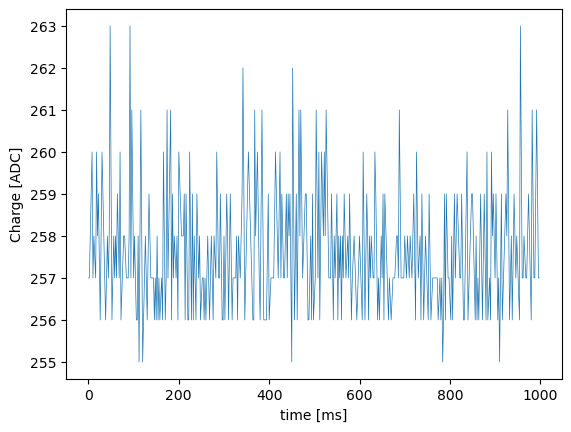

In [16]:
fix, ax = plt.subplots(1, 1)
i = np.random.randint(0, len(output.pixels_id))

ax.plot(
    (output.ucts_timestamp - output.ucts_timestamp[0]) / 1e6,
    output.pedestal_hg[:, i],
    linewidth=0.5,
)
ax.set_ylabel("Charge [ADC]")
ax.set_xlabel("time [ms]")

If you want to load container thereafter : 

In [17]:
container_loaded = MyContainer._container_from_hdf5(
    f"{os.environ.get('NECTARCAMDATA','/tmp')}/tutorials/PedestalTutoNectarCAM_run4943_maxevents500.h5",
    MyContainer,
)
container_loaded.validate()
container_loaded

__main__.MyContainer:
                    run_number: run number associated to the waveforms with
                                default None with type <class 'numpy.uint16'>
                       npixels: number of effective pixels with default None
                                with type <class 'numpy.uint16'>
                     pixels_id: pixel ids with default None as a 1-D array with
                                dtype uint16 with type <class 'numpy.ndarray'>
                ucts_timestamp: events ucts timestamp with default None as a 1-D
                                array with dtype uint64 with type <class
                                'numpy.ndarray'>
                    event_type: trigger event type with default None as a 1-D
                                array with dtype uint8 with type <class
                                'numpy.ndarray'>
                      event_id: event ids with default None as a 1-D array with
                                dtype uin

## Going further

An argument that are implemented in EventsLoopNectarCAMCalibrationTool is the 'event_per_slice', this argument allows to split all the events within the raw data fits.fz file in slices. It allows to, for each slice, loop over events and write container on disk. This mechanism allows to save RAM.
The resulting hdf5 file that is written on disk , can be easily loaded thereafter. There is only one hdf5 file for the whole run, which is a mapping between slices and containers filled by computed quantity from components. 

In [18]:
tool = MyTool(
    progress_bar=True,
    run_number=4943,
    max_events=2000,
    log_level=20,
    events_per_slice=1000,
    overwrite=True,
)
tool

SubComponents,None,". Possible values: ['TelescopeComponent', 'FeatureGenerator', 'QualityQuery', 'EventTypeFilter', 'EventSeeker', 'TableLoader', 'HDF5Merger', 'MuonRingFitter', 'DataWriter', 'SPEalgorithm', 'PhotoStatisticAlgorithm', 'SoftwareTrigger', 'ImageModifier', 'ImageProcessor', 'MuonIntensityFitter', 'MuonProcessor', 'CameraCalibrator', 'NectarCAMR0Corrections', 'TailcutsImageCleaner', 'MARSImageCleaner', 'FACTImageCleaner', 'TimeConstrainedImageCleaner', 'NeighborAverage', 'FullWaveformSum', 'FixedWindowSum', 'GlobalPeakWindowSum', 'LocalPeakWindowSum', 'SlidingWindowMaxSum', 'NeighborPeakWindowSum', 'TwoPassWindowSum', 'FlashCamExtractor', 'BaselineSubtractedNeighborPeakWindowSum', 'NullDataVolumeReducer', 'TailCutsDataVolumeReducer', 'MyComp', 'ChargesComponent', 'WaveformsComponent', 'FlatFieldSingleNominalSPENectarCAMComponent', 'PhotoStatisticNectarCAMComponent', 'FlatFieldSingleNominalSPEStdNectarCAMComponent', 'FlatFieldSingleHHVSPENectarCAMComponent', 'FlatFieldSingleHHVSPEStdNectarCAMComponent', 'FlatFieldCombinedSPEStdNectarCAMComponent', 'ImageQualityQuery', 'ImageParameterQuery', 'RingQuery', 'HDF5TableWriter', 'HDF5TableReader', 'HDF5EventSource', 'SimTelEventSource', 'NectarCAMEventSource', 'LightNectarCAMEventSource', 'ManualGainSelector', 'ThresholdGainSelector', 'SPEnominalalgorithm', 'SPEHHValgorithm', 'SPEnominalStdalgorithm', 'SPECombinedalgorithm', 'SPEHHVStdalgorithm'] (default: None)"
componentsList,['MyComp'],". Possible values: ['MyComp', 'ChargesComponent', 'WaveformsComponent', 'FlatFieldSingleNominalSPENectarCAMComponent', 'PhotoStatisticNectarCAMComponent', 'FlatFieldSingleNominalSPEStdNectarCAMComponent', 'FlatFieldSingleHHVSPENectarCAMComponent', 'FlatFieldSingleHHVSPEStdNectarCAMComponent', 'FlatFieldCombinedSPEStdNectarCAMComponent'] (default: traitlets.Undefined)"
config_files,[],(default: traitlets.Undefined)
events_per_slice,1000,"number of events that will be treat before to pull the buffer and write to disk, if None, all the events will be loaded (default: None)"
log_config,{},(default: traitlets.Undefined)
log_datefmt,%Y-%m-%d %H:%M:%S,The date format used by logging formatters for %(asctime)s (default: %Y-%m-%d %H:%M:%S)
log_file,None,Filename for the log (default: None)
log_file_level,INFO,Logging Level for File Logging (default: INFO)
log_format,[%(name)s]%(highlevel)s %(message)s,The Logging format template (default: [%(name)s]%(highlevel)s %(message)s)
log_level,20,Set the log level by value or name. (default: 30)
logging_config,{},(default: traitlets.Undefined)


In [19]:
tool.initialize()
tool.setup()

2024-01-12 10:52:03,557 WARNING [__main__.PedestalTutoNectarCAM] (loader._handle_unrecognized_alias): Unrecognized alias: 'f', it will have no effect.
2024-01-12 10:52:03,560 INFO [__main__.PedestalTutoNectarCAM] (tool.initialize): Loading config from '[]'
2024-01-12 10:52:03,563 INFO [__main__.PedestalTutoNectarCAM] (tool.initialize): ctapipe version 0.19.1
2024-01-12 10:52:03,564 INFO [__main__.PedestalTutoNectarCAM] (core.setup): setup of the Tool
2024-01-12 10:52:04,153 ctapipe.io.hdf5tableio.HDF5TableReader WARNING Table /tel_0/calibration is missing column time_correction for field time_correction of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2024-01-12 10:52:04,154 ctapipe.io.hdf5tableio.HDF5TableReader WARNING Table /tel_0/calibration is missing column n_pe for field n_pe of container <class 'ctapipe.containers.WaveformCalibrationContainer'>. It will be skipped.
2024-01-12 10:52:04,177 ctapipe.io.hdf5tableio.HDF5TableReader WARNING 

In [20]:
tool.start()

LightNectarCAMEventSource:  50%|████▉     | 993/2000 [00:12<00:09, 103.84ev/s]2024-01-12 10:52:16,706 INFO [__main__.PedestalTutoNectarCAM] (core.start): slice number 1 is full, pulling buffer
2024-01-12 10:52:16,707 INFO [__main__.PedestalTutoNectarCAM] (core._finish_components): finishing components and writting to output file
2024-01-12 10:52:17,282 INFO [__main__.PedestalTutoNectarCAM] (core._init_writer): initilization of writter in sliced mode (slice index = 2)
2024-01-12 10:52:17,289 INFO [__main__.PedestalTutoNectarCAM] (core._setup_components): setup of components
LightNectarCAMEventSource: 100%|█████████▉| 1996/2000 [00:24<00:00, 104.24ev/s]2024-01-12 10:52:29,342 INFO [__main__.PedestalTutoNectarCAM] (core.start): slice number 2 is full, pulling buffer
2024-01-12 10:52:29,344 INFO [__main__.PedestalTutoNectarCAM] (core._finish_components): finishing components and writting to output file
2024-01-12 10:52:29,915 INFO [__main__.PedestalTutoNectarCAM] (core._init_writer): initi

In [21]:
output = tool.finish(return_output_component=True)[0]
output

2024-01-12 10:52:29,953 INFO [__main__.PedestalTutoNectarCAM] (core.finish): finishing Tool
2024-01-12 10:52:29,956 INFO [__main__.PedestalTutoNectarCAM] (core._finish_components): finishing components and writting to output file
2024-01-12 10:52:29,957 WARNING [nectarchain.makers.core] (core._write_container): MyContainer Field 'pedestal_hg': the value '[]' (<class 'numpy.ndarray'>) is invalid:  Should have dimensionality 2
Traceback (most recent call last):
  File "/home/ggroller/.conda/envs/nectarchain/lib/python3.11/site-packages/ctapipe/core/container.py", line 455, in validate
    field.validate(self[name])
  File "/home/ggroller/.conda/envs/nectarchain/lib/python3.11/site-packages/ctapipe/core/container.py", line 189, in validate
    raise FieldValidationError(
ctapipe.core.container.FieldValidationError: the value '[]' (<class 'numpy.ndarray'>) is invalid:  Should have dimensionality 2

During handling of the above exception, another exception occurred:

Traceback (most recent 

__main__.MyContainer:
                    run_number: run number associated to the waveforms with
                                default None with type <class 'numpy.uint16'>
                       npixels: number of effective pixels with default None
                                with type <class 'numpy.uint16'>
                     pixels_id: pixel ids with default None as a 1-D array with
                                dtype uint16 with type <class 'numpy.ndarray'>
                ucts_timestamp: events ucts timestamp with default None as a 1-D
                                array with dtype uint64 with type <class
                                'numpy.ndarray'>
                    event_type: trigger event type with default None as a 1-D
                                array with dtype uint8 with type <class
                                'numpy.ndarray'>
                      event_id: event ids with default None as a 1-D array with
                                dtype uin

In [22]:
!h5ls -r $NECTARCAMDATA/tutorials/PedestalTutoNectarCAM_run4943_maxevents2000.h5

/                        Group
/data_1                  Group
/data_1/MyContainer      Dataset {1/Inf}
/data_2                  Group
/data_2/MyContainer      Dataset {1/Inf}


In [23]:
# container_loaded = ArrayDataContainer._container_from_hdf5(f"{os.environ.get('NECTARCAMDATA','/tmp')}/tutorials/PedestalTutoNectarCAM_run4943_maxevents2000.h5",MyContainer)
# container_loaded

In [24]:
def read_hdf5_sliced(path):
    container = MyContainer()
    container_class = MyContainer
    with HDF5TableReader(path) as reader:
        for data in reader._h5file.root.__members__:
            # print(data)
            data_cont = eval(f"reader._h5file.root.{data}.__members__")[0]
            # print(data_cont)
            tableReader = reader.read(
                table_name=f"/{data}/{data_cont}", containers=container_class
            )
            # container.containers[data].containers[trigger] = next(tableReader)
            container = next(tableReader)
            yield container

In [25]:
container_loaded = read_hdf5_sliced(
    f"{os.environ.get('NECTARCAMDATA','/tmp')}/tutorials/PedestalTutoNectarCAM_run4943_maxevents2000.h5"
)
for i, container in enumerate(container_loaded):
    print(
        f"Container {i} is filled by events from {container.event_id[0]} to {container.event_id[-1]}"
    )

Container 0 is filled by events from 2002 to 4000
Container 1 is filled by events from 2 to 2000
